In [1]:
from getpass import getpass
token = getpass("Paste your GitHub classic token (hidden): ")


Paste your GitHub classic token (hidden): ··········


In [2]:
# run in a new cell (replace owner/repo if different)
!git clone https://$token@github.com/zeinashaarawy/DataOrbit.git
%cd DataOrbit
!git fetch origin
!git checkout Jana  || git checkout -b Jana origin/Jana
!git pull origin main
!git branch -a


Cloning into 'DataOrbit'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 75 (delta 18), reused 45 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 29.40 MiB | 10.08 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (8/8), done.
/content/DataOrbit
Branch 'Jana' set up to track remote branch 'Jana' from 'origin'.
Switched to a new branch 'Jana'
From https://github.com/zeinashaarawy/DataOrbit
 * branch            main       -> FETCH_HEAD
hint: You have divergent branches and need to specify how to reconcile them.
hint: You can do so by running one of the following commands sometime before
hint: your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --

In [3]:
import sklearn, imblearn, xgboost, joblib, pandas
print("sklearn", sklearn.__version__, "imblearn", imblearn.__version__, "xgboost", xgboost.__version__)


sklearn 1.6.1 imblearn 0.14.0 xgboost 3.1.2


In [4]:

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

def save_model(estimator, name, folder="models"):
    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, f"{name}.joblib")
    joblib.dump(estimator, path)
    print(f"Saved model -> {path}")


In [5]:
DATA_PATH = "/content/DataOrbit/data/provider_final_features.csv"

# Check if file exists
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found. Check folder structure in Colab.")

# Load data
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
display(df.head())

# ------------------------------
# Detect binary target column
# ------------------------------
possible_targets = ['Fraud','IsFraud','label','Label','target','TARGET','fraud']
target_col = None

# Check for common target names
for c in df.columns:
    if c in possible_targets:
        target_col = c
        break

# Fallback: any column with 2 unique values
if target_col is None:
    for c in df.columns:
        if df[c].nunique() == 2:
            target_col = c
            break

if target_col is None:
    raise ValueError("Could not detect binary target column. "
                     "Rename the fraud label to something like: Fraud, Label, target, IsFraud.")

print("Using target:", target_col)

# Map Yes/No → 1/0 if needed
if df[target_col].dtype == object:
    df[target_col] = df[target_col].map({'Yes':1, 'No':0, 'YES':1, 'NO':0, 'yes':1, 'no':0}).fillna(df[target_col])

# If still not numeric, map unique values to 0/1
if df[target_col].dtype == object:
    uniq = sorted(df[target_col].unique())
    mapping = {v:i for i,v in enumerate(uniq)}
    df[target_col] = df[target_col].map(mapping)

# Prepare X and y
y = df[target_col].astype(int)
X = df.drop(columns=[target_col])

# Drop ID-like columns if present
for idcol in ['Provider','BeneID','ID','index']:
    if idcol in X.columns:
        X = X.drop(columns=[idcol])

# Only numeric features for modeling (student-level version)
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numeric_features]

print("Final X shape:", X.shape)
print("Positive ratio:", y.mean())


Raw shape: (5410, 28)


,provider,ip_claim_sum,ip_claim_mean,ip_claim_max,ip_deductible_sum,ip_deductible_mean,ip_unique_patients,ip_deceased_patients,op_claim_sum,op_claim_mean,...,total_deductible_sum,total_deductible_mean,total_unique_patients,total_deceased_patients,deceased_patient_ratio,claim_per_patient,ip_op_claim_ratio,ip_max_mean_ratio,chronic_cond_ratio,avg_claim_per_deceased
0,PRV51001,97000.0,19400.000000,42000.0,5340.0,1068.0,5.0,0.0,7640.0,382.000000,...,5340.0,222.499991,24.0,0.0,0.000000,4359.999818,12.696335,2.164948,0.0,0.0
1,PRV51003,573000.0,9241.935484,57000.0,66216.0,1068.0,53.0,1.0,32670.0,466.714286,...,66286.0,557.025205,119.0,1.0,0.008403,5089.663823,17.539027,6.167539,0.0,605670.0
2,PRV51004,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,52170.0,350.134228,...,310.0,2.246377,138.0,1.0,0.007246,378.043476,0.000000,0.000000,0.0,52170.0
3,PRV51005,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,280910.0,241.124464,...,3700.0,7.474747,495.0,4.0,0.008081,567.494948,0.000000,0.000000,0.0,70227.5
4,PRV51007,19000.0,6333.333333,10000.0,3204.0,1068.0,3.0,0.0,14710.0,213.188406,...,3264.0,55.322033,59.0,1.0,0.016949,571.355923,1.291638,1.578947,0.0,33710.0


Using target: potentialfraud
Final X shape: (5410, 26)
Positive ratio: 0.09353049907578559


In [9]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train positive ratio:", y_train.mean(), "Test positive ratio:", y_test.mean())


Train shape: (4328, 26) Test shape: (1082, 26)
Train positive ratio: 0.09357670979667283 Test positive ratio: 0.0933456561922366


In [10]:

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features)], remainder='drop')

def make_pipeline(clf, imbalance='none'):
    """
    imbalance: 'none' | 'smote' | 'undersample'
    clf: classifier instance (expects to be named 'clf' in pipeline)
    """
    if imbalance == 'smote':
        pipe = ImbPipeline(steps=[('preproc', preprocessor), ('smote', SMOTE(random_state=42)), ('clf', clf)])
    elif imbalance == 'undersample':
        pipe = ImbPipeline(steps=[('preproc', preprocessor), ('under', RandomUnderSampler(random_state=42)), ('clf', clf)])
    else:
        pipe = Pipeline(steps=[('preproc', preprocessor), ('clf', clf)])
    return pipe



In [11]:
neg = len(y_train) - y_train.sum()
pos = y_train.sum()
scale_pos = max(1, int(neg / max(1, pos)))

print("Negative samples:", neg)
print("Positive samples:", pos)
print("scale_pos_weight:", scale_pos)

Negative samples: 3923
Positive samples: 405
scale_pos_weight: 9


In [12]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

models = {}
params = {}

models['xgb_smote'] = make_pipeline(xgb, imbalance='smote')

params['xgb_smote'] = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 6],
    'clf__learning_rate': [0.05, 0.1]
}

print("XGBoost (SMOTE) model added.")

XGBoost (SMOTE) model added.


In [13]:
xgb_weight = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos,   # class weighting
    random_state=42
)

models['xgb_weighted'] = make_pipeline(xgb_weight, imbalance='none')

params['xgb_weighted'] = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 6],
    'clf__learning_rate': [0.05, 0.1]
}

print("XGBoost (Weighted) model added.")

XGBoost (Weighted) model added.


In [14]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

models['rf'] = make_pipeline(rf, imbalance='none')

params['rf'] = {
    'clf__n_estimators': [100],
    'clf__max_depth': [None, 10]
}

print("Random Forest model added.")

Random Forest model added.


In [15]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga')

models['logreg'] = make_pipeline(lr, imbalance='none')

params['logreg'] = {
    'clf__C': [0.1, 1.0]
}

print("Logistic Regression model added.")

Logistic Regression model added.


In [16]:
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

models['dt'] = make_pipeline(dt, imbalance='none')

params['dt'] = {
    'clf__max_depth': [None, 5, 10]
}

print("Decision Tree model added.")

Decision Tree model added.


In [17]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)  # small CV so it runs faster in Colab
best_models = {}
tuning_summary = []

for name, pipeline in models.items():
    print(f"--- Tuning {name} ---")
    grid = GridSearchCV(pipeline, param_grid=params[name], scoring='f1', cv=cv, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best CV f1 for {name}: {grid.best_score_:.4f}")
    print("Best params:", grid.best_params_)
    tuning_summary.append({'model': name, 'best_cv_f1': grid.best_score_, 'best_params': grid.best_params_})

tuning_df = pd.DataFrame(tuning_summary).sort_values('best_cv_f1', ascending=False).reset_index(drop=True)
display(tuning_df)


--- Tuning xgb_smote ---
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:55:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best CV f1 for xgb_smote: 0.5659
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 6, 'clf__n_estimators': 200}
--- Tuning xgb_weighted ---
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:55:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best CV f1 for xgb_weighted: 0.5898
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 6, 'clf__n_estimators': 200}
--- Tuning rf ---
Fitting 4 folds for each of 2 candidates, totalling 8 fits
Best CV f1 for rf: 0.6005
Best params: {'clf__max_depth': 10, 'clf__n_estimators': 100}
--- Tuning logreg ---
Fitting 4 folds for each of 2 candidates, totalling 8 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best CV f1 for logreg: 0.5380
Best params: {'clf__C': 0.1}
--- Tuning dt ---
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Best CV f1 for dt: 0.5238
Best params: {'clf__max_depth': 10}


,model,best_cv_f1,best_params
0,rf,0.600528,"{'clf__max_depth': 10, 'clf__n_estimators': 100}"
1,xgb_weighted,0.589801,"{'clf__learning_rate': 0.05, 'clf__max_depth':..."
2,xgb_smote,0.565850,"{'clf__learning_rate': 0.05, 'clf__max_depth':..."
3,logreg,0.538035,{'clf__C': 0.1}
4,dt,0.523763,{'clf__max_depth': 10}


In [18]:
os.makedirs("models", exist_ok=True)
for name, est in best_models.items():
    save_model(est, name, folder="models")
print("All models saved in ./models/")

Saved model -> models/xgb_smote.joblib
Saved model -> models/xgb_weighted.joblib
Saved model -> models/rf.joblib
Saved model -> models/logreg.joblib
Saved model -> models/dt.joblib
All models saved in ./models/


In [19]:
metrics_rows = []
for name, est in best_models.items():
    # ensure we feed preprocessed X_test through pipeline
    y_pred = est.predict(X_test)
    try:
        y_proba = est.predict_proba(X_test)[:,1]
    except Exception:
        # if no predict_proba, use decision_function
        y_proba = est.decision_function(X_test)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else np.nan
    pr_auc = average_precision_score(y_test, y_proba)
    metrics_rows.append({
        'model': name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc,
        'pr_auc': pr_auc
    })

metrics_df = pd.DataFrame(metrics_rows).sort_values('f1', ascending=False).reset_index(drop=True)
display(metrics_df)
# Save basic comparison table
metrics_df.to_csv("models/model_comparison_table.csv", index=False)
print("Saved model_comparison_table.csv in models/")

,model,precision,recall,f1,roc_auc,pr_auc
0,rf,0.586466,0.772277,0.666667,0.950959,0.717399
1,xgb_weighted,0.506250,0.801980,0.620690,0.953099,0.740214
2,xgb_smote,0.484663,0.782178,0.598485,0.946771,0.723301
3,dt,0.451429,0.782178,0.572464,0.861719,0.569296
4,logreg,0.393665,0.861386,0.540373,0.949244,0.738546


Saved model_comparison_table.csv in models/


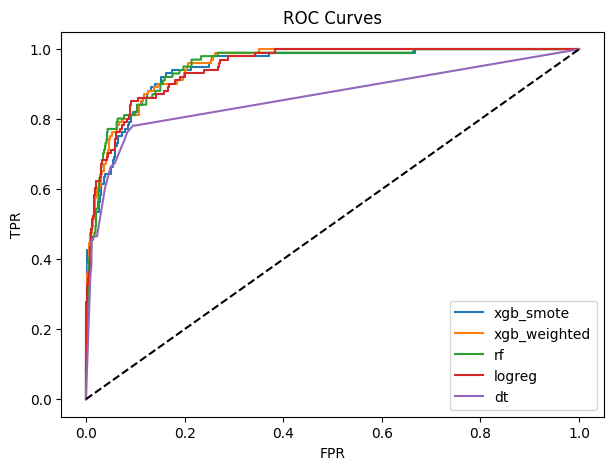

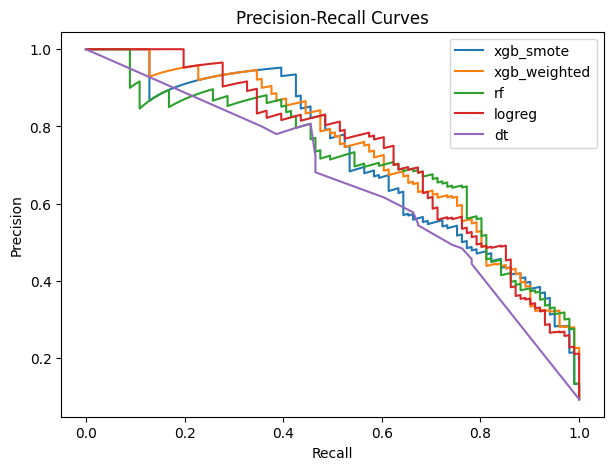

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

plt.figure(figsize=(7,5))
for name, est in best_models.items():
    y_proba = est.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
for name, est in best_models.items():
    y_proba = est.predict_proba(X_test)[:,1]
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(rec, prec, label=name)
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

In [21]:
!git checkout Jana

M	models/logreg.joblib
Already on 'Jana'
Your branch is up to date with 'origin/Jana'.


In [22]:
%cd /content/DataOrbit


/content/DataOrbit


In [ ]:
!git add models/


In [23]:
!git config --global user.email "jannasaeed2005@gmail.com"
!git config --global user.name "Jana Saeed"


In [ ]:
!git commit -m "Add trained models folder"

[Jana 168b27e] Add trained models folder
 6 files changed, 6 insertions(+)
 create mode 100644 models/dt.joblib
 create mode 100644 models/logreg.joblib
 create mode 100644 models/model_comparison_table.csv
 create mode 100644 models/rf.joblib
 create mode 100644 models/xgb_smote.joblib
 create mode 100644 models/xgb_weighted.joblib


In [ ]:
!git push origin Jana


Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 2 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 1021.62 KiB | 6.23 MiB/s, done.
Total 9 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), done.
To https://github.com/zeinashaarawy/DataOrbit.git
   ba50939..168b27e  Jana -> Jana


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
!SRC="/content/drive/MyDrive/Colab Notebooks/Copy of 02-modeling.ipynb"
!DST="/content/DataOrbit/notebooks/02-modeling.ipynb"

mkdir -p /content/DataOrbit/notebooks

if [ -f "$SRC" ]; then
  cp "$SRC" "$DST" && echo "Copied to repo: $DST"
else
  echo "Source file not found: $SRC"
fi

ls -la /content/DataOrbit/notebooks


SyntaxError: invalid syntax. Perhaps you forgot a comma? (ipython-input-289204397.py, line 6)